In [1]:
# %pip install pillow==2.2.1
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, LeakyReLU,BatchNormalization, Add,Dropout
from tensorflow.keras.models import Model
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy,SparseCategoricalCrossentropy


Segmentation Models: using `keras` framework.


In [2]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2.10.1
Num GPUs Available:  1


In [3]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random
import tensorflow as tf
from PIL import Image

# import tensorflow_addons as tfa


In [4]:
train_img_dir = "data/data_for_keras_aug/train_images/train/"
train_mask_dir = "data/data_for_keras_aug/train_masks/train/"

In [5]:
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [6]:
num_images = len(os.listdir(train_img_dir))

In [7]:
img_num = random.randint(0, num_images-1)

In [8]:
img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

In [9]:
mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

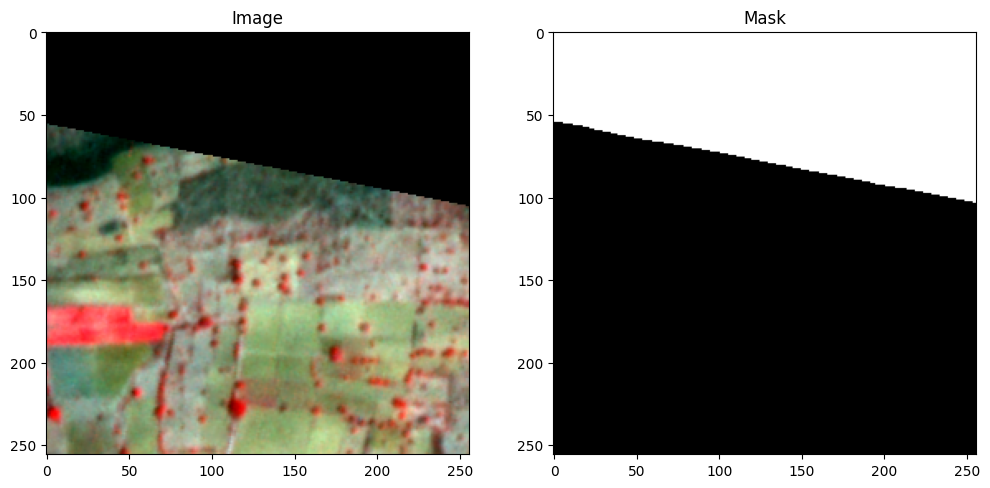

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


## Defining seed size

In [11]:
seed=24
batch_size= 8
n_classes=2

In [12]:
# %pip install -U scikit-learn

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

## Backbone

In [14]:
#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

## Preprocessing

In [15]:

def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = mask / 255.0  # Normalize mask values to [0, 1]
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Train Generator

In [17]:
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [18]:
train_img_path = "data/data_for_keras_aug/train_images/"
train_mask_path = "data/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=2)

In [19]:
x, y = train_img_gen.__next__()

Found 606 images belonging to 1 classes.
Found 606 images belonging to 1 classes.


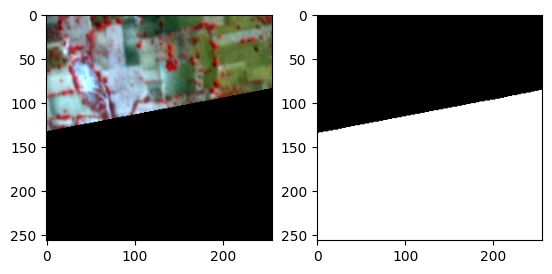

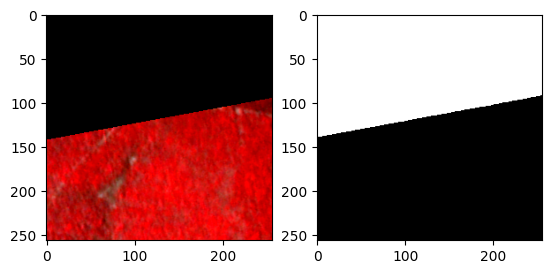

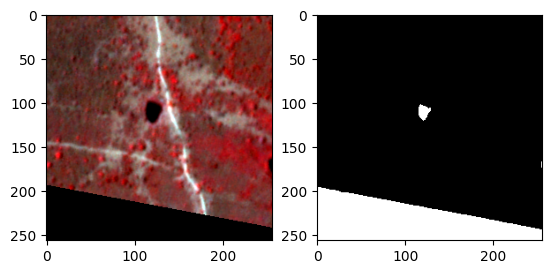

In [20]:
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [21]:
val_img_path = "data/data_for_keras_aug/val_images/"
val_mask_path = "data/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=2)

In [22]:
x_val, y_val = val_img_gen.__next__()

Found 203 images belonging to 1 classes.
Found 203 images belonging to 1 classes.


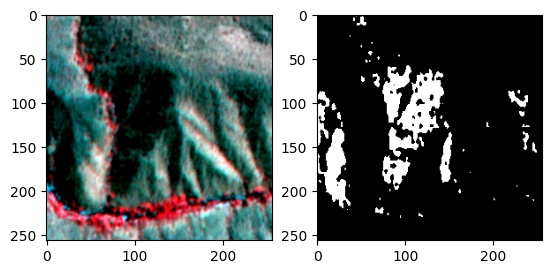

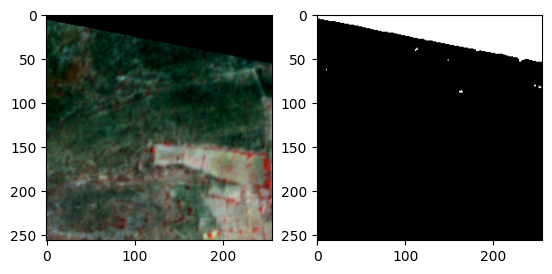

In [23]:
for i in range(0,2):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [24]:
num_train_imgs = len(os.listdir('data/data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('data/data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

In [25]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]


In [26]:
IMG_CHANNELS

3

In [27]:
y.shape[3]

2

In [28]:
n_classes=2

### Custom Loss

In [29]:
import tensorflow as tf


class DiceLoss(tf.keras.losses.Loss):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def call(self, y_true, y_pred):
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
        dice = (2.0 * intersection + 1e-7) / (union + 1e-7)
        return 1.0 - dice  


def custom_loss(y_true, y_pred):
    y_true_float = tf.cast(y_true, tf.float32)
    dice_loss = DiceLoss()(y_true_float, y_pred)
    l2_reg = 0.01  
    l2_loss = l2_reg * tf.reduce_sum([tf.reduce_mean(tf.square(w)) for w in tf.compat.v1.trainable_variables()])
    focal_loss_value = sm.losses.categorical_focal_loss(y_true, y_pred)
    combined_loss = dice_loss + l2_loss
    
    return combined_loss


In [30]:

dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

## Weighted cross entropy Loss

In [31]:
# import tensorflow as tf


# class WeightedCrossEntropyLoss(tf.keras.losses.Loss):
#     def __init__(self, weight_pos=1.0, weight_neg=1.0):
#         super(WeightedCrossEntropyLoss, self).__init__()
#         self.weight_pos = weight_pos
#         self.weight_neg = weight_neg

#     def call(self, y_true, y_pred):
#         # Compute weighted cross-entropy loss
#         loss = tf.reduce_mean(
#             tf.nn.weighted_cross_entropy_with_logits(
#                 labels=y_true, logits=y_pred, pos_weight=self.weight_pos, name="weighted_cross_entropy_loss"
#             )
#         )

#         return loss


# def custom_loss(y_true, y_pred):
#     # Convert y_true to float32
#     y_true_float = tf.cast(y_true, tf.float32)

#     # Use WeightedCrossEntropyLoss directly
#     loss = WeightedCrossEntropyLoss(weight_pos=1.0, weight_neg=1.0)(y_true_float, y_pred)

#     return loss


##  GAP Loss


In [32]:
# import tensorflow as tf

# class WeightedCrossEntropyLoss(tf.keras.losses.Loss):
#     def __init__(self, weight_pos=1.0, weight_neg=1.0):
#         super(WeightedCrossEntropyLoss, self).__init__()
#         self.weight_pos = weight_pos
#         self.weight_neg = weight_neg

#     def call(self, y_true, y_pred):
#         # Compute weighted cross-entropy loss
#         loss = tf.reduce_mean(
#             tf.nn.weighted_cross_entropy_with_logits(
#                 labels=y_true, logits=y_pred, pos_weight=self.weight_pos, name="weighted_cross_entropy_loss"
#             )
#         )

#         return loss


# def custom_loss(y_true, y_pred):
#     # Convert y_true to float32
#     y_true_float = tf.cast(y_true, tf.float32)

#     # Use WeightedCrossEntropyLoss directly
#     loss = WeightedCrossEntropyLoss(weight_pos=1.0, weight_neg=1.0)(y_true_float, y_pred)

#     return loss


### GIOU Loss

In [33]:
# import tensorflow as tf

# class GeneralizedIoULoss(tf.keras.losses.Loss):
#     def __init__(self, epsilon=1e-7):
#         super(GeneralizedIoULoss, self).__init__()
#         self.epsilon = epsilon

#     def call(self, y_true, y_pred):
#         # Calculate intersection and union
#         intersection = tf.reduce_sum(y_true * y_pred)
#         union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

#         # Calculate IoU (Intersection over Union)
#         iou = (intersection + self.epsilon) / (union + self.epsilon)

#         # Calculate GIoU (Generalized Intersection over Union)
#         c_y_true = tf.reduce_sum(y_true, axis=[1, 2, 3])
#         c_y_pred = tf.reduce_sum(y_pred, axis=[1, 2, 3])
#         c_intersection = tf.reduce_sum(tf.minimum(c_y_true, c_y_pred))
#         c_union = tf.reduce_sum(tf.maximum(c_y_true, c_y_pred))

#         giou = iou - (c_union - c_intersection) / (c_union + self.epsilon)

#         # Calculate GIoU Loss
#         giou_loss = 1.0 - giou

#         return giou_loss


# def custom_loss(y_true, y_pred):
#     # Convert y_true to float32
#     y_true_float = tf.cast(y_true, tf.float32)

#     # Use GeneralizedIoULoss directly
#     loss = GeneralizedIoULoss()(y_true_float, y_pred)

#     return loss


### Dice Loss

In [34]:
# import tensorflow as tf

# class DiceLoss(tf.keras.losses.Loss):
#     def __init__(self, epsilon=1e-7):
#         super(DiceLoss, self).__init__()
#         self.epsilon = epsilon

#     def call(self, y_true, y_pred):
#         # Flatten y_true and y_pred
#         y_true = tf.reshape(y_true, [-1])
#         y_pred = tf.reshape(y_pred, [-1])

#         # Calculate intersection and union
#         intersection = tf.reduce_sum(y_true * y_pred)
#         union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

#         # Calculate Dice coefficient
#         dice = (2.0 * intersection + self.epsilon) / (union + self.epsilon)

#         # Calculate Dice Loss
#         dice_loss = 1.0 - dice

#         return dice_loss


# def custom_loss(y_true, y_pred):
#     # Use DiceLoss directly
#     loss = DiceLoss()(y_true, y_pred)

#     return loss


In [35]:
import tensorflow as tf

def dice_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = 1 - (2.0 * intersection + 1e-7) / (union + 1e-7)
    return dice

### Unet_Custom

In [36]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model

def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=2000,
    decay_rate=0.9)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss=total_loss, metrics=['accuracy', IOUScore()])
    model.summary()
    return model


model = multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 dropout_7 (Dropout)            (None, 128, 128, 32  0           ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

### Unet++

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, LeakyReLU,BatchNormalization, Add,Dropout
from tensorflow.keras.models import Model
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy,SparseCategoricalCrossentropy

def conv_block(inputs, filters, kernel_size=5, activation='relu', padding='same'):
    conv1 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv2 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv1)
    conv3 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv2)
#     conv = Dropout(0.2)(conv) 
    return conv3
def build_unetplusplus(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 1024)
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = conv_block(up6, 512)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = conv_block(up7, 256)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = conv_block(up8, 128)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = conv_block(up9, 64)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define hyperparameters
lr = 3e-4
batch_size = 16
epochs = 50
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Create a U-Net++ model for multi-class segmentation (e.g., num_classes=3 for 3 classes)
model = build_unetplusplus(input_shape=(256, 256, 3), num_classes=2)

# Compile the model with categorical cross-entropy loss and appropriate metrics
#bestLoss='categorical_crossentropy'
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', IOUScore()])


### Unet++ LSTM

In [38]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, LSTM, Reshape
from tensorflow.keras.models import Model
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv

def build_unetplusplus_with_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 1024)
    
    # Reshape before LSTM
    lstm_input_shape = (16*16, 1024)  # Flattened to treat as a sequence
    lstm = Reshape(lstm_input_shape)(conv5)
    
    # LSTM layer
    lstm = LSTM(512, return_sequences=True)(lstm)
    
    # Reshape after LSTM
    lstm_output_shape = (16, 16, 512)  # Reshape back to original shape
    lstm = Reshape(lstm_output_shape)(lstm)
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(lstm), conv4], axis=-1)
    conv6 = conv_block(up6, 512)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = conv_block(up7, 256)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = conv_block(up8, 128)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = conv_block(up9, 64)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define hyperparameters
lr = 3e-4
batch_size = 16
epochs = 50

# Create a U-Net++ model with LSTM layer
model_with_lstm = build_unetplusplus_with_lstm(input_shape=(256, 256, 3), num_classes=2)

# Compile the model with categorical cross-entropy loss and appropriate metrics
model_with_lstm.compile(optimizer=Adam(), loss=DiceLoss(), metrics=['accuracy', IOUScore()])

# Print model summary
model_with_lstm.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_48 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_47[0][0]']              
                                )                                                           

                                2)                                'conv2d_48[0][0]']              
                                                                                                  
 conv2d_63 (Conv2D)             (None, 256, 256, 64  110656      ['concatenate_11[0][0]']         
                                )                                                                 
                                                                                                  
 conv2d_64 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_63[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 256, 256, 2)  130         ['conv2d_64[0][0]']              
                                                                                                  
Total para

### Unet ++ with LSTM and Dropout

In [34]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, LSTM, Reshape, Dropout
from tensorflow.keras.models import Model
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from segmentation_models.losses import DiceLoss

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = Dropout(0.2)(conv)  # Adding dropout layer with a dropout rate of 20%
    return conv

def build_unetplusplus_with_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 1024)
    
    # Reshape before LSTM
    lstm_input_shape = (16*16, 1024)  # Flattened to treat as a sequence
    lstm = Reshape(lstm_input_shape)(conv5)
    
    # LSTM layer
    lstm = LSTM(512, return_sequences=True)(lstm)
    
    # Reshape after LSTM
    lstm_output_shape = (16, 16, 512)  # Reshape back to original shape
    lstm = Reshape(lstm_output_shape)(lstm)
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(lstm), conv4], axis=-1)
    conv6 = conv_block(up6, 512)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = conv_block(up7, 256)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = conv_block(up8, 128)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = conv_block(up9, 64)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define hyperparameters
learning_rate = 3e-4
batch_size = 16
epochs = 50
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=200,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate)
model_with_lstm = build_unetplusplus_with_lstm(input_shape=(256, 256, 3), num_classes=2)

model_with_lstm.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', IOUScore()])

model_with_lstm.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

                                6)                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 128, 128, 38  0           ['up_sampling2d_2[0][0]',        
                                4)                                'dropout_1[0][0]']              
                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 12  442496      ['concatenate_2[0][0]']          
                                8)                                                                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 12  147584      ['conv2d_14[0][0]']              
                                8)                                                                
          

### Model

In [77]:
from segmentation_models import Linknet
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from segmentation_models import Linknet



In [51]:
model = sm.Linknet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=2, activation='softmax')



In [52]:
#adam_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
# # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
# # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
# # sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
# # # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [81]:
# # sm.losses.categorical_focal_jaccard_loss
from segmentation_models.losses import DiceLoss
model.compile(optimizer=optimizer, loss= total_loss,  metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
# print(model.summary())
# print(model.input_shape)

### FCN

In [32]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization,Reshape, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = BatchNormalization()(conv)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = BatchNormalization()(conv)
    return conv

def build_fcn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 1024)

    
    # Upsampling
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    upconv6 = conv_block(up6, 512)

    up7 = concatenate([UpSampling2D(size=(2, 2))(upconv6), conv3], axis=-1)
    upconv7 = conv_block(up7, 256)

    up8 = concatenate([UpSampling2D(size=(2, 2))(upconv7), conv2], axis=-1)
    upconv8 = conv_block(up8, 128)

    up9 = concatenate([UpSampling2D(size=(2, 2))(upconv8), conv1], axis=-1)
    upconv9 = conv_block(up9, 64)

    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(upconv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model


input_shape = (256, 256, 3) 
num_classes = 2 

model = build_fcn(input_shape, num_classes)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', IOUScore()])


### ResUnet with LSTM

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, LSTM, Reshape, Dropout, Add
from tensorflow.keras.models import Model
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from segmentation_models.losses import DiceLoss

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = Dropout(0.2)(conv)  # Adding dropout layer with a dropout rate of 20%
    return conv

def res_conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv1 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv2 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv1)
    conv2 = Dropout(0.2)(conv2)  # Adding dropout layer with a dropout rate of 20%
    
    # Adjust the shape of inputs to match conv2 before adding
    adjusted_inputs = Conv2D(filters, 1, padding='same')(inputs)
    
    residual = Add()([conv2, adjusted_inputs])  # Residual connection
    return residual


def build_resunet_with_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = res_conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = res_conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = res_conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = res_conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = res_conv_block(pool4, 1024)
    
    # Reshape before LSTM
    lstm_input_shape = (16*16, 1024)  # Flattened to treat as a sequence
    lstm = Reshape(lstm_input_shape)(conv5)
    
    # LSTM layer
    lstm = LSTM(512, return_sequences=True)(lstm)
    
    # Reshape after LSTM
    lstm_output_shape = (16, 16, 512)  # Reshape back to original shape
    lstm = Reshape(lstm_output_shape)(lstm)
    
    # Decoder with residual connections
    up6 = UpSampling2D(size=(2, 2))(lstm)
    up6 = concatenate([up6, conv4], axis=-1)
    conv6 = res_conv_block(up6, 512)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=-1)
    conv7 = res_conv_block(up7, 256)
    
    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=-1)
    conv8 = res_conv_block(up8, 128)
    
    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=-1)
    conv9 = res_conv_block(up9, 64)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

lr = 3e-4
batch_size = 16
epochs = 50


model_resunet_with_lstm = build_resunet_with_lstm(input_shape=(256, 256, 3), num_classes=2)
model_resunet_with_lstm.compile(optimizer=Adam(lr=lr), loss=, metrics=['accuracy', IOUScore()])

model_resunet_with_lstm.summary()


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy', IOUScore()])

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.models import Model

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv

def build_unet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 1024)
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = conv_block(up6, 512)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = conv_block(up7, 256)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = conv_block(up8, 128)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = conv_block(up9, 64)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define hyperparameters
lr = 3e-4
batch_size = 16
epochs = 50


model_unet = build_unet(input_shape=(256, 256, 3), num_classes=2)


model_unet.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy', IOUScore()])

model_unet.summary()


### Train

In [36]:


from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

checkpoint = ModelCheckpoint('Unetpp_LSTM_Dropout_AdamSoftmax503e4.hdf5',
                             monitor='val_iou_score', 
                             save_best_only=True,  
                              mode='max', 
                             verbose=1,
                             
                            )

# reduce_lr = ReduceLROnPlateau(monitor='val_iou_score', factor=0.9, patience=10, min_lr=1e-7, verbose=1)
callbacks = [EarlyStopping(monitor='val_iou_score',patience=100, restore_best_weights=True)]
callbacks = [checkpoint]



history = model_with_lstm.fit(train_img_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    verbose=1,
                    validation_data=val_img_gen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=callbacks)



Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.2947 - accuracy: 0.9250 - iou_score: 0.6970
Epoch 1: val_iou_score improved from -inf to 0.89484, saving model to Unetpp_LSTM_Dropout_AdamSoftmax503e4.hdf5
75/75 [==============================] - 41s 551ms/step - loss: 0.2947 - accuracy: 0.9250 - iou_score: 0.6970 - val_loss: 0.1095 - val_accuracy: 0.9631 - val_iou_score: 0.8948
Epoch 2/50
75/75 [==============================] - ETA: 0s - loss: 0.0968 - accuracy: 0.9688 - iou_score: 0.8940
Epoch 2: val_iou_score improved from 0.89484 to 0.91030, saving model to Unetpp_LSTM_Dropout_AdamSoftmax503e4.hdf5
75/75 [==============================] - 29s 390ms/step - loss: 0.0968 - accuracy: 0.9688 - iou_score: 0.8940 - val_loss: 0.1007 - val_accuracy: 0.9693 - val_iou_score: 0.9103
Epoch 3/50
75/75 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9696 - iou_score: 0.9000
Epoch 3: val_iou_score did not improve from 0.91030
75/75 [====================

Epoch 24/50
75/75 [==============================] - ETA: 0s - loss: 0.0786 - accuracy: 0.9763 - iou_score: 0.9179
Epoch 24: val_iou_score did not improve from 0.93638
75/75 [==============================] - 29s 383ms/step - loss: 0.0786 - accuracy: 0.9763 - iou_score: 0.9179 - val_loss: 0.0638 - val_accuracy: 0.9793 - val_iou_score: 0.9279
Epoch 25/50
75/75 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9783 - iou_score: 0.9244
Epoch 25: val_iou_score improved from 0.93638 to 0.93795, saving model to Unetpp_LSTM_Dropout_AdamSoftmax503e4.hdf5
75/75 [==============================] - 30s 399ms/step - loss: 0.0709 - accuracy: 0.9783 - iou_score: 0.9244 - val_loss: 0.0956 - val_accuracy: 0.9753 - val_iou_score: 0.9380
Epoch 26/50
75/75 [==============================] - ETA: 0s - loss: 0.0619 - accuracy: 0.9805 - iou_score: 0.9332
Epoch 26: val_iou_score did not improve from 0.93795
75/75 [==============================] - 29s 385ms/step - loss: 0.0619 - accuracy

Epoch 48/50
75/75 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9830 - iou_score: 0.9422
Epoch 48: val_iou_score did not improve from 0.93795
75/75 [==============================] - 29s 382ms/step - loss: 0.0491 - accuracy: 0.9830 - iou_score: 0.9422 - val_loss: 0.0609 - val_accuracy: 0.9816 - val_iou_score: 0.9378
Epoch 49/50
75/75 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9805 - iou_score: 0.9340
Epoch 49: val_iou_score did not improve from 0.93795
75/75 [==============================] - 29s 382ms/step - loss: 0.0629 - accuracy: 0.9805 - iou_score: 0.9340 - val_loss: 0.0740 - val_accuracy: 0.9778 - val_iou_score: 0.9366
Epoch 50/50
75/75 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9801 - iou_score: 0.9355
Epoch 50: val_iou_score did not improve from 0.93795
75/75 [==============================] - 29s 382ms/step - loss: 0.0606 - accuracy: 0.9801 - iou_score: 0.9355 - val_loss: 0.0743 - val_accuracy:

## Loss

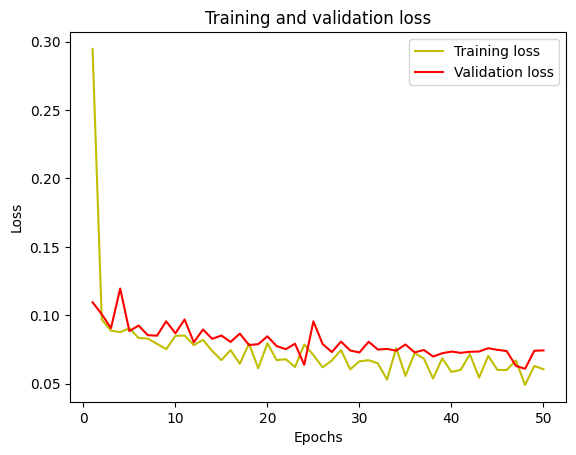

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

## IOU

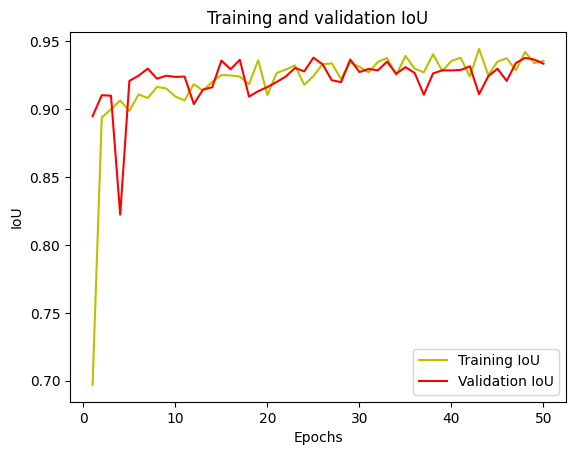

In [43]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

### Accuracy

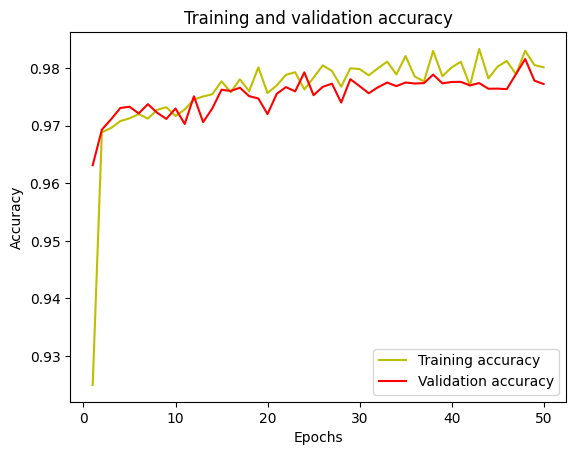

In [44]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Accuracy

In [47]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

model = load_model("Unetpp_LSTM_Dropout_AdamSoftmax503e4.hdf5", compile=False)

# Test generator using validation data.
test_image_batch, test_mask_batch = val_img_gen.__next__()

# Convert categorical to integer for visualization and accuracy calculation

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

# Calculate accuracy
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(test_mask_batch_argmax, test_pred_batch_argmax)
print("Accuracy =", accuracy.result().numpy())

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# Flatten the arrays for classification report and confusion matrix
test_mask_flat = test_mask_batch_argmax.flatten()
test_pred_flat = test_pred_batch_argmax.flatten()

# Calculate and print the classification report
class_report = classification_report(test_mask_flat, test_pred_flat)
print("Classification Report:\n", class_report)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(test_mask_flat, test_pred_flat)
print("Confusion Matrix:\n", conf_matrix)



1/1 [==============================] - 1s 538ms/step
Accuracy = 0.98578835
Mean IoU = 0.9712332
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    305185
           1       0.98      0.98      0.98    219103

    accuracy                           0.99    524288
   macro avg       0.99      0.99      0.99    524288
weighted avg       0.99      0.99      0.99    524288

Confusion Matrix:
 [[301112   4073]
 [  3378 215725]]


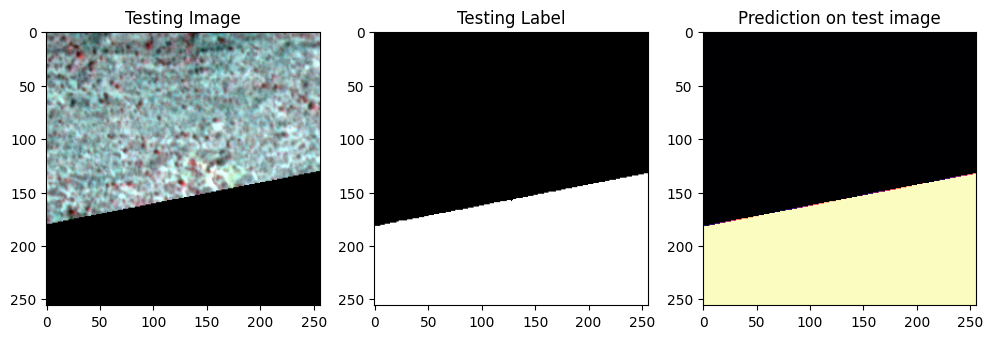

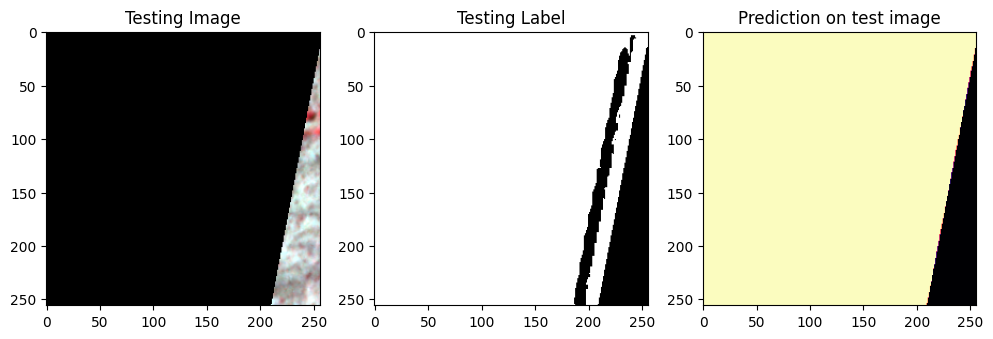

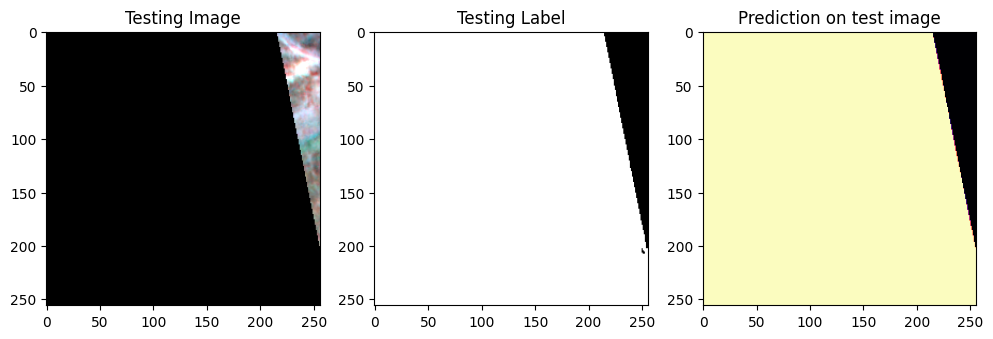

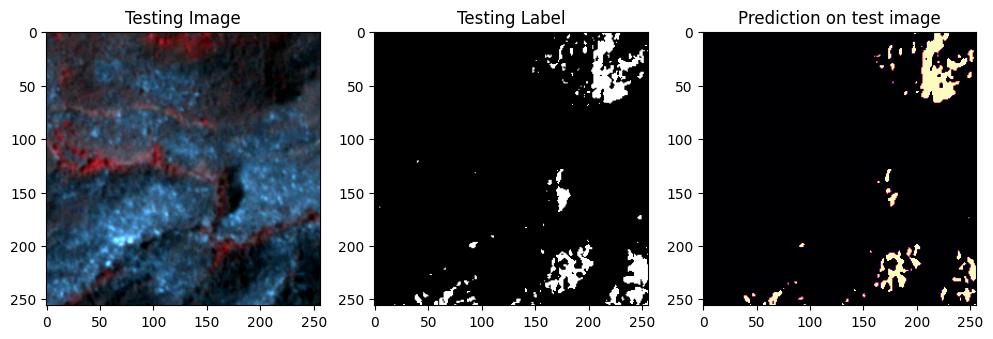

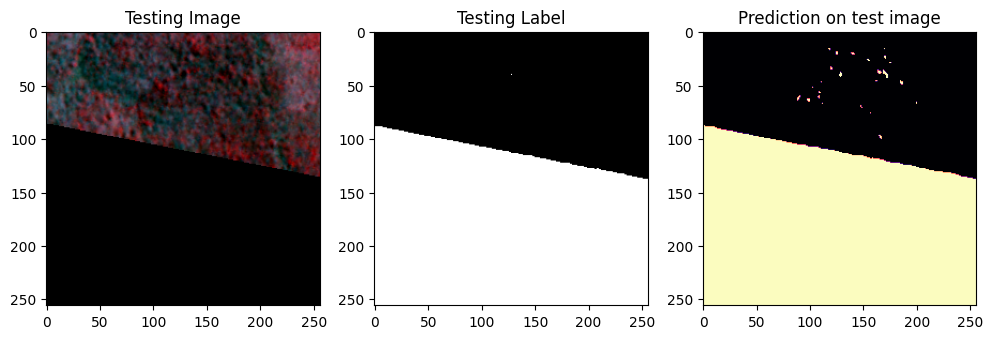

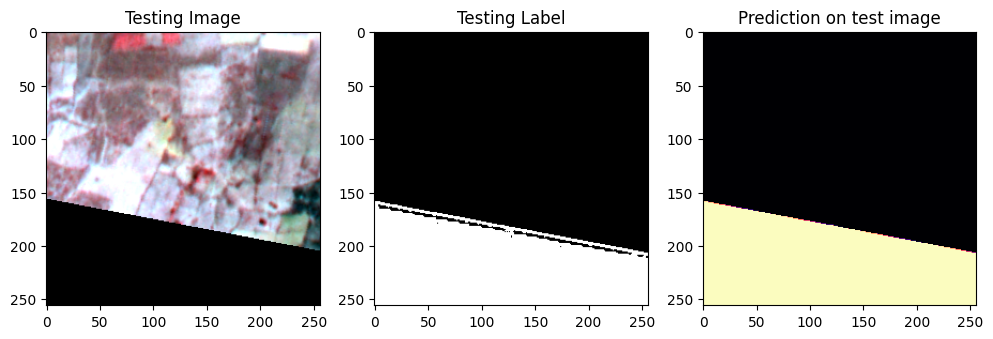

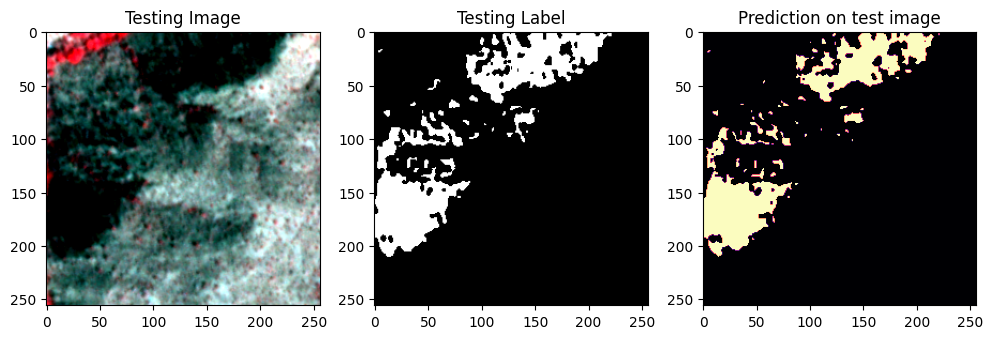

In [48]:
for x in range(0, test_image_batch.shape[0]-1):
    img_num=x
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_image_batch[img_num])
    
    plt.subplot(232)
    plt.title('Testing Label')

    plt.imshow(test_mask_batch_argmax[img_num],cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_pred_batch_argmax[img_num],cmap='magma')
    plt.show()
